# NOTEBOOK DEEPSEEK INFERENCE RANDOM SAMPLES (BALANCED)
## MULTICLASS CLASSIFICATION WITH THE MODEL TRAINED WITH MORE SAMPLES

This notebook evaluates the DeepSeek LLM previously trained using fine-tuning prompting for multiclass classification in inference mode. In this notebook, we evaluate the model's performance. 

## 1. Objectives

The objective of this notebook is to evaluate the inference performance of the DeepSeek LLM,  
which was previously fine-tuned on a larger and more diverse multiclass dataset.

Specifically, this notebook aims to:
- Assess the model's ability to distinguish between **normal** traffic and various **types of attacks** (e.g., XSS, SQL Injection, DDoS...) in a realistic inference scenario.
- Analyze its predictions on unseen data and evaluate its generalization capabilities after training on a broader set of balanced samples.
- Compare its performance to both classical ML baselines and smaller fine-tuned versions to contextualize improvements and trade-offs.

## 2. IMPORTS AND SETUP
Import the required python libraries, preprocessing, inference of the fine-tuning and evaluation.

In [ ]:
# Core modules for file handling and JSON
import os
import json
# PyTorch for model inference
import torch
# Data manipulation and progress tracking
import pandas as pd
from tqdm import tqdm
# Hugging Face datasets for structured input
from datasets import Dataset
# Evaluation metrics for classification tasks
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
# For default dictionary behavior
from collections import defaultdict
# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
# Unsloth: optimized LLM loading
from unsloth import FastLanguageModel
from transformers import AutoTokenizer

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# Configuration for the model and data
model_path = "../../fine-tuned-model-attacks/deepseek_finetuned_model_multi"
file_path = "../../../../../data/prompts/multiclass_instructions_for_inference_more_samples.jsonl"
max_seq_length = 2048
use_4bit = True
save_csv = True
csv_output_path = "../../outputs/results_deepseek_multiclass_greater.csv"

In [ ]:
# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)
model, _ = FastLanguageModel.from_pretrained(
    model_name=model_path,
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=use_4bit,
)
FastLanguageModel.for_inference(model)
model.eval()

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4060 Laptop GPU. Max memory: 7.996 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.2.15 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

## 3. LOAD DATA FOR INFERENCE

In [ ]:
# Load dataset for inference
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

samples = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        sample = json.loads(line.strip())
        samples.append({"text": sample["Prompt"]})
dataset = Dataset.from_list(samples)

# Append EOS token
EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    return {"text": [entry + EOS_TOKEN for entry in examples["text"]]}

dataset = dataset.map(formatting_prompts_func, batched=True)

Map: 100%|██████████| 20415/20415 [00:00<00:00, 261982.79 examples/s]


## 3. INFERENCE

In [ ]:
# Attack labels
attack_types = [
    "Normal", "DDoS_UDP", "DDoS_ICMP", "SQL_injection", "Password",
    "Vulnerability_scanner", "DDoS_TCP", "DDoS_HTTP", "Uploading", "Backdoor",
    "Port_Scanning", "XSS", "Ransomware", "MITM", "Fingerprinting"
]

attack_type_to_id = {attack: i for i, attack in enumerate(attack_types)}
id_to_attack_type = {i: attack for i, attack in enumerate(attack_types)}

def label_to_multiclass(text):
    """Convert response text to a multi-class attack label (integer ID)."""
    text = text.lower().strip()
    for attack in attack_types:
        if attack.lower() in text:
            return attack_type_to_id[attack]
    return attack_type_to_id["Normal"]  # Default



In [ ]:
# Inference
predictions_multiclass = []
actual_labels_multiclass = []

for sample in tqdm(dataset, desc="Processing test samples", unit="sample"):
    full_text = sample["text"]

    if "### Response:" in full_text:
        input_text, actual_label = full_text.split("### Response:")
        input_text = input_text.strip()
        actual_label = label_to_multiclass(actual_label.strip())
    else:
        input_text = full_text.strip()
        actual_label = attack_type_to_id["Normal"]

    inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=30,
            use_cache=True,
        )

    predicted_response = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    if "### Response:" in predicted_response:
        predicted_label = label_to_multiclass(predicted_response.split("### Response:")[1].strip())
    else:
        predicted_label = attack_type_to_id["Normal"]
    predictions_multiclass.append(predicted_label)
    actual_labels_multiclass.append(actual_label)



Processing test samples: 100%|██████████| 20415/20415 [10:11:19<00:00,  1.80s/sample] 


## 4. EVALUATION

### GENERAL METRICS

In [ ]:
# Evaluation
print("\n📊 Classification Report:")
print(classification_report(
    actual_labels_multiclass,
    predictions_multiclass,
    target_names=attack_types,
    zero_division=0
))


📊 Classification Report:
                       precision    recall  f1-score   support

               Normal       1.00      1.00      1.00      1400
             DDoS_UDP       0.29      0.20      0.23      1400
            DDoS_ICMP       0.30      0.24      0.27      1400
        SQL_injection       0.97      0.99      0.98      1400
             Password       1.00      0.97      0.98      1400
Vulnerability_scanner       1.00      0.99      1.00      1400
             DDoS_TCP       0.52      0.88      0.66      1400
            DDoS_HTTP       0.99      0.99      0.99      1400
            Uploading       0.91      0.97      0.94      1400
             Backdoor       1.00      0.92      0.96      1400
        Port_Scanning       0.64      0.11      0.18      1400
                  XSS       0.91      0.92      0.91      1400
           Ransomware       0.92      0.92      0.92      1400
                 MITM       0.31      0.64      0.42      1214
       Fingerprinting       

In [8]:
# Compute Multi-Class Evaluation Metrics
accuracy = accuracy_score(actual_labels_multiclass, predictions_multiclass)
precision = precision_score(actual_labels_multiclass, predictions_multiclass, average="weighted", zero_division=0)
recall = recall_score(actual_labels_multiclass, predictions_multiclass, average="weighted", zero_division=0)
f1 = f1_score(actual_labels_multiclass, predictions_multiclass, average="weighted", zero_division=0)

# Print results
print("\nMulti-Class Evaluation General Results:")
print(f" -Accuracy: {accuracy:.4f}")
print(f" -Precision (Weighted): {precision:.4f}")
print(f" -Recall (Weighted): {recall:.4f}")
print(f" -F1-score (Weighted): {f1:.4f}")


Multi-Class Evaluation General Results:
 -Accuracy: 0.7404
 -Precision (Weighted): 0.7496
 -Recall (Weighted): 0.7404
 -F1-score (Weighted): 0.7239


### METRICS PER CLASS

In [9]:
# Compute Per-Class Metrics
class_metrics = defaultdict(dict)
for attack_id in set(actual_labels_multiclass):
    attack_name = id_to_attack_type[attack_id]

    if attack_id in predictions_multiclass:
        class_metrics[attack_name]["Precision"] = precision_score(actual_labels_multiclass, predictions_multiclass, labels=[attack_id], average="macro", zero_division=0)
        class_metrics[attack_name]["Recall"] = recall_score(actual_labels_multiclass, predictions_multiclass, labels=[attack_id], average="macro", zero_division=0)
        class_metrics[attack_name]["F1-score"] = f1_score(actual_labels_multiclass, predictions_multiclass, labels=[attack_id], average="macro", zero_division=0)
    else:
        class_metrics[attack_name] = {"Precision": 0, "Recall": 0, "F1-score": 0}  # Set default values if no predictions

# Print per-class metrics
print("\n\nPer-Class Performance:")
for attack, metrics in class_metrics.items():
    print(f"{attack:25s} | Precision: {metrics['Precision']:.4f} | Recall: {metrics['Recall']:.4f} | F1-score: {metrics['F1-score']:.4f}")



Per-Class Performance:
Normal                    | Precision: 1.0000 | Recall: 1.0000 | F1-score: 1.0000
DDoS_UDP                  | Precision: 0.2918 | Recall: 0.1957 | F1-score: 0.2343
DDoS_ICMP                 | Precision: 0.2991 | Recall: 0.2436 | F1-score: 0.2685
SQL_injection             | Precision: 0.9666 | Recall: 0.9914 | F1-score: 0.9788
Password                  | Precision: 0.9985 | Recall: 0.9671 | F1-score: 0.9826
Vulnerability_scanner     | Precision: 0.9993 | Recall: 0.9929 | F1-score: 0.9961
DDoS_TCP                  | Precision: 0.5216 | Recall: 0.8807 | F1-score: 0.6552
DDoS_HTTP                 | Precision: 0.9878 | Recall: 0.9871 | F1-score: 0.9875
Uploading                 | Precision: 0.9088 | Recall: 0.9679 | F1-score: 0.9374
Backdoor                  | Precision: 0.9985 | Recall: 0.9214 | F1-score: 0.9584
Port_Scanning             | Precision: 0.6371 | Recall: 0.1079 | F1-score: 0.1845
XSS                       | Precision: 0.9095 | Recall: 0.9193 | F1-score

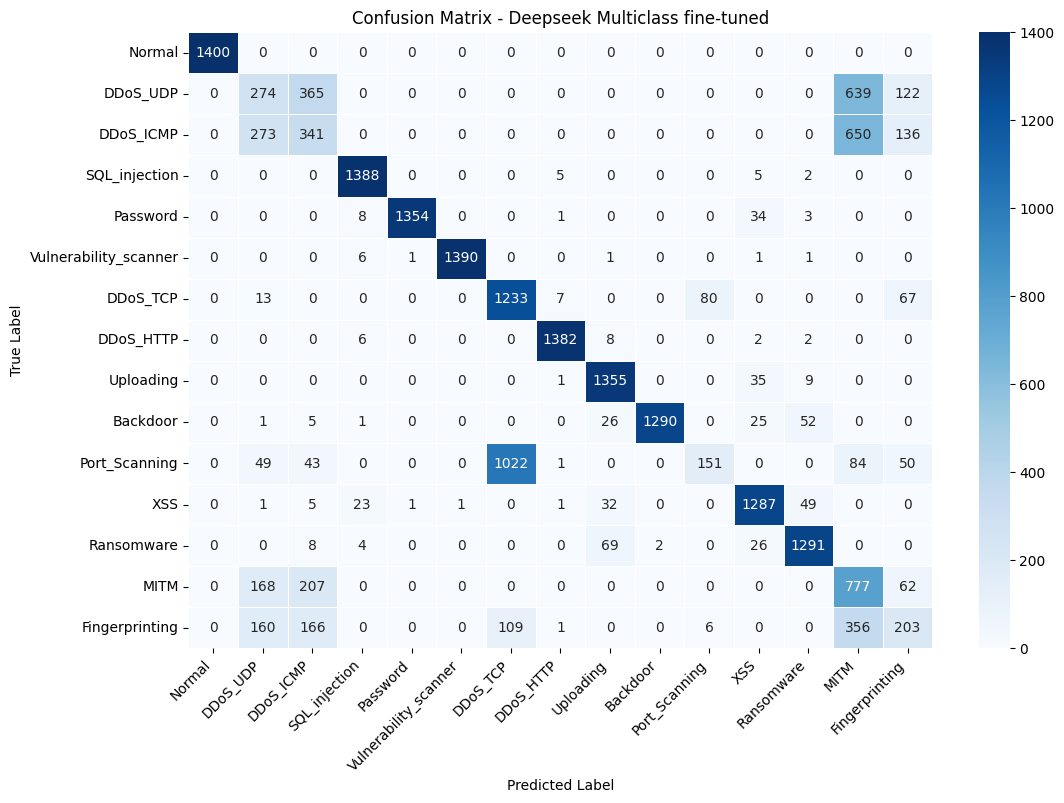

In [10]:
# Convert numeric labels back to attack type names
actual_labels_str = [id_to_attack_type[label] for label in actual_labels_multiclass]
predictions_str = [id_to_attack_type[label] for label in predictions_multiclass]

# Compute the confusion matrix
cm = confusion_matrix(actual_labels_str, predictions_str, labels=attack_types)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=attack_types, columns=attack_types)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Deepseek Multiclass fine-tuned")
plt.xticks(rotation=45, ha="right")  # Rotate labels for better readability
plt.yticks(rotation=0)

# Show the plot
plt.show()

## 5. SAVE RESULTS

In [ ]:
# Save results
if save_csv:
    df = pd.DataFrame({
        "true_label": [id_to_attack_type[i] for i in actual_labels_multiclass],
        "predicted_label": [id_to_attack_type[i] for i in predictions_multiclass],
    })
    os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)
    df.to_csv(csv_output_path, index=False)